In [3]:
import pandas as pd

train_data = pd.read_csv("emnist-byclass-train.csv", header = None)
test_data = pd.read_csv("emnist-byclass-test.csv", header = None)
mapping = pd.read_csv("emnist-byclass-mapping.txt", sep = ' ', header = None)

In [4]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


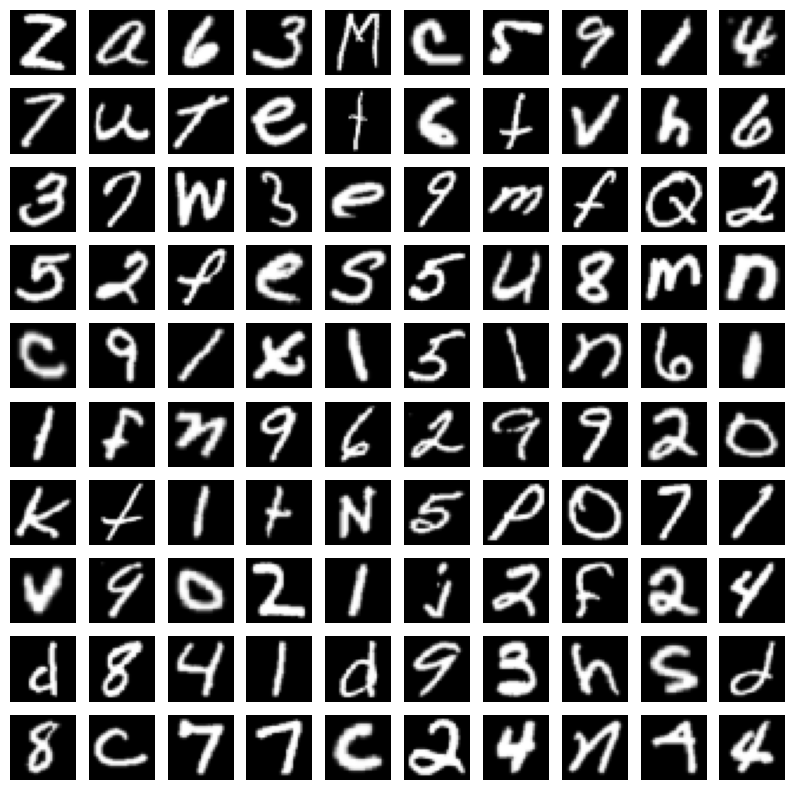

In [9]:
# display a 10x10 grid of images, each 28x28 image from the first 100 rows
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(10, 10, figsize = (10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(train_data.iloc[i * 10 + j, 1:].values.reshape(28, 28).T, cmap = 'gray')
        ax[i, j].axis('off')
plt.show()

In [10]:
# print the label of the first 100 images
print(train_data.iloc[:100, 0].values)

# 35 is uppercase z
# 36 is lowercase a
# 6 is 6
# so logically its digits first, then uppercase letters, then lowercase letters

[35 36  6  3 22 38  5  9 47  4  7 56 29 40 55  6 55 57 43  6  3  7 32  3
 40  9 22 15 26  2  5  2 15 40 28  5 56  8 22 49 12  9  1 59  1  5 47 49
  6 18  1 41 49  9  6  2  9  9  2  0 46 55  1 55 23  5 51 24  7  1 31  9
 24  2  1 45  2 15  2  4 39  8  4  1 39  9  3 43 28 39  8 38  7  7 38  2
  4 49  4  4]


In [17]:
# prune away all digits
train_data = train_data[train_data.iloc[:, 0] >= 10]
test_data = test_data[test_data.iloc[:, 0] >= 10]

# change indexes to start from 0
train_data.iloc[:, 0] -= 10
test_data.iloc[:, 0] -= 10

In [51]:
letter_mapping = [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]
letter_mapping

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [52]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
# save the first 5 rows of train_data to a file, one line and entries comma separated
train_data.iloc[:5].to_csv("first_5_rows.csv", index = False, header = False)

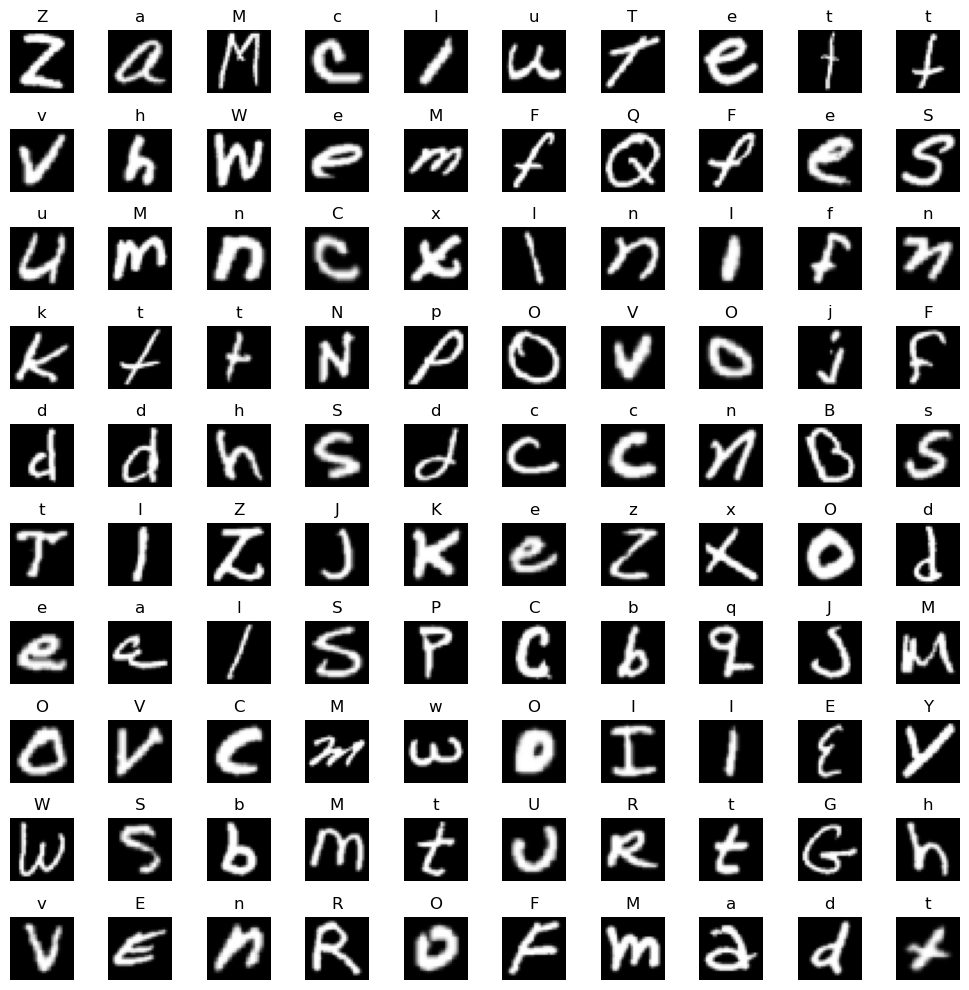

In [53]:
fig, ax = plt.subplots(10, 10, figsize = (10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(train_data.iloc[i * 10 + j, 1:].values.reshape(28, 28).T, cmap = 'gray')
        ax[i, j].axis('off')
        # caption the image with the letter
        ax[i, j].set_title(letter_mapping[train_data.iloc[i * 10 + j, 0]])

plt.tight_layout()
plt.show()

In [97]:
# create Dataset and DataLoader
from torch.utils.data import Dataset, DataLoader
import torch

class EMNISTDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # the label should be a 52 element one-hot vector
        label = torch.zeros(52)
        label[self.data.iloc[idx, 0]] = 1
        return torch.tensor(self.data.iloc[idx, 1:].values), label

train_dataset = EMNISTDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming train_dataloader is already defined and loaded with your dataset

# Define the CNN Model
class EMNIST_CNN(nn.Module):
    def __init__(self):
        super(EMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 52)  # 52 classes

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Reshape from [784] to [1, 28, 28]
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 7*7*64)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Check if a GPU is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EMNIST_CNN().to(device)

In [99]:
from tqdm import tqdm

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_dataloader, criterion, optimizer, num_epochs=2):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        # Wrap the dataloader with tqdm for a progress bar
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            images = images.float()  # Convert images to float

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update the running loss for printing average loss later
            running_loss += loss.item() * images.size(0)
            
            # Update the progress bar with the loss information
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} complete, Avg Loss: {epoch_loss:.4f}')


# Call the training function
train_model(model, train_loader, criterion, optimizer)

Epoch 1/2: 100%|██████████| 5515/5515 [03:24<00:00, 26.91it/s, loss=0.595]


Epoch 1/2 complete, Avg Loss: 1.3133


Epoch 2/2: 100%|██████████| 5515/5515 [03:10<00:00, 28.98it/s, loss=0.307]

Epoch 2/2 complete, Avg Loss: 0.8148


In [102]:
# inference
model.eval()
test_dataset = EMNISTDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.float()
        labels = labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        labels = torch.argmax(labels, dim=1)

        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')

Accuracy of the network on the test images: 82.42616214365208%


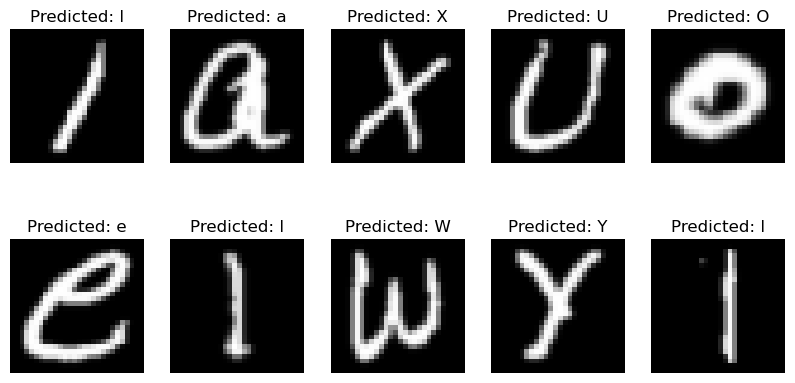

In [103]:
# visualize on the first 10 images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))

model.eval()

with torch.no_grad():
    for i in range(10):
        image, label = test_dataset[i]
        image = image.to(device)
        image = image.float()
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)
        ax[i//5, i%5].imshow(image.cpu().numpy().reshape(28, 28).T, cmap='gray')
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title(f'Predicted: {letter_mapping[predicted.item()]}')
plt.show()

# Convert to Tensorflow

In [106]:
import torch.onnx
import torch

# Assuming model is your trained PyTorch model
model.eval()

# Create a sample input tensor of the appropriate size
# Example for a model that takes a single channel 28x28 image
sample_input = torch.randn(1, 1, 28, 28)

# Specify the path for the ONNX file
onnx_model_path = 'model.onnx'

# Export the model
torch.onnx.export(model, sample_input, onnx_model_path, export_params=True, opset_version=11,
                  do_constant_folding=True, input_names=['input'], output_names=['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}})

In [107]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX model
onnx_model = onnx.load(onnx_model_path)

# Prepare the TensorFlow representation
tf_rep = prepare(onnx_model)

# Export the model to a TensorFlow SavedModel
tf_model_path = 'model_tf'
tf_rep.export_graph(tf_model_path)

/opt/homebrew/anaconda3/envs/cs229/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
INFO:absl:Function `__call__` contains input name(s) x with unsupported characters which will be renamed to transpose_11_x in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_tf/assets


INFO:tensorflow:Assets written to: model_tf/assets
INFO:absl:Writing fingerprint to model_tf/fingerprint.pb


In [110]:
# convert model to graph tsjs model
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(tf_rep, 'model_tfjs')

AttributeError: 'TensorflowRep' object has no attribute 'save'

In [108]:
import tensorflow as tf

# Load the TensorFlow model
tf_model = tf.saved_model.load('model_tf')


TypeError: Binding inputs to tf.function failed due to `too many positional arguments`. Received args: (<tf.Tensor: shape=(1, 784), dtype=float32, numpy=
array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,  20.,  37.,  18.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   9.,  47.,
        159., 213., 108.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   9.,  77., 140., 209., 247., 250., 127.,   4.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   8.,  34.,  96., 219., 251.,
        254., 254., 230., 109.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,
         47., 207., 245., 252., 255., 234., 204., 127.,  22.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   4.,  46., 127., 209., 253., 254., 246., 220.,
         96.,  34.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  33., 115., 209.,
        246., 254., 253., 221., 128.,  50.,   7.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,  32.,  52., 164., 244., 254., 253., 234., 202.,  91.,  10.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   7.,  37.,  51., 128., 244., 251., 254., 252.,
        209., 127.,  34.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   4.,   9.,  34.,  96., 215.,
        222., 246., 252., 250., 244., 175.,  46.,   9.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         29., 121., 136., 200., 230., 250., 250., 249., 177., 129., 113.,
         34.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,  49., 122., 123., 126., 127.,
        127., 127., 126.,  34.,   5.,   4.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.]], dtype=float32)>,) and kwargs: {'training': False} for signature: (**kwargs).

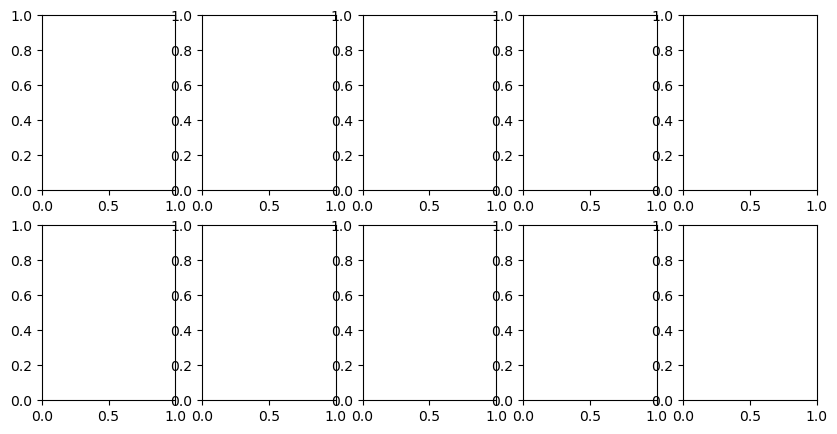

In [109]:
import matplotlib.pyplot as plt

# Assuming test_dataset is loaded and accessible
fig, ax = plt.subplots(2, 5, figsize=(10, 5))

for i in range(10):
    image, label = test_dataset[i]
    image = tf.convert_to_tensor(image, dtype=tf.float32)  # Convert to TensorFlow tensor
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    # Inference
    output = tf_model(image, training=False)  # Make sure to run the model in inference mode
    predicted = tf.argmax(output, axis=1)
    
    # Assuming images are 28x28 and grayscale
    ax[i//5, i%5].imshow(image.numpy().reshape(28, 28).T, cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(f'Predicted: {letter_mapping[predicted.numpy()[0]]}')
plt.show()


# Siamese Here, Ignore

In [ ]:
# create Dataset and DataLoader
from torch.utils.data import Dataset, DataLoader
import torch

class EMNISTDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image1, label1 = self.data.iloc[idx, 1:].values, self.data.iloc[idx, 0]

        # image2 is from same class (positive example)
        label1_indices = np.where(self.data.iloc[:, 0] == label1)[0]
        image2_index = np.random.choice(label1_indices)
        image2 = self.data.iloc[image2_index, 1:].values

        # image3 is from different class (negative example)
        label2 = np.random.choice(np.setdiff1d(range(52), label1))
        label2_indices = np.where(self.data.iloc[:, 0] == label2)[0]
        image3_index = np.random.choice(label2_indices)
        image3 = self.data.iloc[image3_index, 1:].values

        return image1, image2, image3
    
train_dataset = EMNISTDataset(train_data_float)
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, in_features),
            nn.ReLU()
        )

    def forward(self, x):
        return x + self.block(x)  # Adding input x to the output of the block

class SIAMVAE(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(SIAMVAE, self).__init__()
        self.latent_dim = latent_dim

        # EEG encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            ResidualBlock(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            ResidualBlock(128),
            nn.Linear(128, latent_dim * 2)  # Outputting mean and log-variance
        )

        # Decoder with residual blocks
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            ResidualBlock(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            ResidualBlock(256),
            nn.Linear(256, input_size),
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, eeg):
        latent = self.encoder(eeg)

        # Split the result into mean and log-variance
        mu, log_var = torch.chunk(latent, 2, dim=1)

        z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, z, mu, log_var

latent_dim = 64
model = SIAMVAE(784, latent_dim)

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming siamese_network is your Siamese Network model
# and triplet_loss is your contrastive loss function

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
siavae = model.to(device)
num_epochs = 10

triplet_loss = nn.TripletMarginLoss(reduction='mean')

recon_losses = []
kl_losses = []
siamese_losses = []

def siamese_loss_weight(epoch, start_epoch=10, end_epoch=20):
    if epoch < start_epoch:
        return 0.0
    elif epoch > end_epoch:
        return 1.0
    else:
        optimizer.lr = 0.0001
        return (epoch - start_epoch) / (end_epoch - start_epoch)

# Example training loop
for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)

    total_recon_loss, total_kl_loss, total_siamese_loss = 0, 0, 0

    for anchor, positive, negative in loop:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        # Forward pass for VAE (reconstruction) and Siamese (embeddings)
        reconstructed_anchor, anchor_embedding, anchor_mu, anchor_log_var = siavae(anchor)
        reconstructed_positive, positive_embedding, positive_mu, positive_log_var = siavae(positive)
        reconstructed_negative, negative_embedding, negative_mu, negative_log_var = siavae(negative)

        # positive_embedding_detached = positive_embedding.detach()
        # negative_embedding_detached = negative_embedding.detach()

        # Compute VAE loss
        recon_loss = F.mse_loss(reconstructed_anchor, anchor, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + anchor_log_var - anchor_mu.pow(2) - anchor_log_var.exp())
        siamese_loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)

        loss = 0.0015 * recon_loss + 0.0003 * kl_loss + siamese_loss

        # Accumulate losses
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_siamese_loss += siamese_loss.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(recon_loss=total_recon_loss, kl_loss=total_kl_loss, siamese_loss=total_siamese_loss)

    loop.close()

    num_batches = len(train_loader)
    recon_losses.append(total_recon_loss / num_batches)
    kl_losses.append(total_kl_loss / num_batches)
    siamese_losses.append(total_siamese_loss / num_batches)

Epoch [1/10]:  70%|███████   | 972/1379 [04:37<01:56,  3.50it/s, kl_loss=1.46e+17, recon_loss=3.92e+15, siamese_loss=1.12e+9]


KeyboardInterrupt: 